In [186]:
import numpy as np
import pandas as pd

from biom import (load_table,
                  Table)
from qiime2 import (Artifact,
                    Metadata, Visualization)
from qiime2.plugins.feature_table.actions import (rarefy)

from qiime2.plugins.gemelli.actions import (rpca)
from qiime2.plugins.mmvec.actions import (paired_omics,
                                          summarize_paired)
from sklearn.model_selection import train_test_split
from skbio import OrdinationResults, DistanceMatrix
from skbio.stats.distance import permanova
from skbio.stats.composition import closure

# plotting
import colorsys
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mc
from matplotlib.pyplot import cm
from matplotlib.colors import to_hex

#plt.style.use('ggplot')
plt.style.use('seaborn') 
%matplotlib inline

def match_all_table_subset(bt1, bt2, bt3, mf, 
                           use_catagory_col,
                           use_catagory_subset,
                           filter_for_strat = None,
                           min_sample_count = 100,
                           min_feature_count = 2,
                           min_feature_samples = 10):
    
    # subset
    mf_subset = mf.copy()[mf[use_catagory_col] == use_catagory_subset]

    # copy and filter
    bt1_subset = bt1.copy()
    bt2_subset = bt2.copy()
    bt3_subset = bt3.copy()
    shared_ids = set(mf_subset.index) & set(bt1_subset.ids()) & set(bt2_subset.ids())  & set(bt3_subset.ids())
    bt1_subset = bt1_subset.filter(shared_ids)
    bt2_subset = bt2_subset.filter(shared_ids)
    bt3_subset = bt3_subset.filter(shared_ids)
    mf_subset = mf_subset.loc[shared_ids, :]
    
    # filter sample to min seq. depth
    def sample_filter(val, id_, md):
        return sum(val) > min_sample_count
    # filter features to min total counts
    def observation_filter(val, id_, md):
        return sum(val) > min_feature_count
    # filter features by N samples presence
    def frequency_filter(val, id_, md):
        return np.sum(val > 0) > min_feature_samples
    
    # filter bt1
    n_features, n_samples = bt1_subset.shape
    bt1_subset = bt1_subset.filter(observation_filter, axis='observation')
    bt1_subset = bt1_subset.filter(frequency_filter, axis='observation')
    bt1_subset = bt1_subset.filter(sample_filter, axis='sample')
    # filter bt2
    n_features, n_samples = bt2_subset.shape
    bt2_subset = bt2_subset.filter(observation_filter, axis='observation')
    bt2_subset = bt2_subset.filter(frequency_filter, axis='observation')
    bt2_subset = bt2_subset.filter(sample_filter, axis='sample')
    # filt bt3
    bt3_subset = bt3_subset.filter(frequency_filter, axis='observation')
    bt3_subset = Table(closure(bt3_subset.matrix_data.toarray().T).T,
                       bt3_subset.ids('observation'),
                       bt3_subset.ids())

    
    # double check all shared
    shared_ids = set(mf_subset.index) & set(bt1_subset.ids()) & set(bt2_subset.ids())  & set(bt3_subset.ids())
    mf_subset = mf_subset.loc[shared_ids, :]
    if filter_for_strat is not None:
        use_catagory_col2_counts = mf_subset[filter_for_strat].value_counts()
        use_catagory_col2_counts = use_catagory_col2_counts[use_catagory_col2_counts > len(use_catagory_col2_counts)].index
        mf_subset = mf_subset[mf_subset[filter_for_strat].isin(use_catagory_col2_counts)]
       
    shared_ids = set(mf_subset.index) & set(bt1_subset.ids()) & set(bt2_subset.ids())
    bt1_subset = bt1_subset.filter(shared_ids)
    bt2_subset = bt2_subset.filter(shared_ids)
    bt3_subset = bt3_subset.filter(shared_ids)
    mf_subset = mf_subset.loc[shared_ids, :]
    # close the data - easier to generalize the mmvec params.
    bt3_subset = Table(closure(bt3_subset.matrix_data.toarray().T).T,
                       bt3_subset.ids('observation'),
                       bt3_subset.ids())
    bt2_subset = Table(closure(bt2_subset.matrix_data.toarray().T).T,
                       bt2_subset.ids('observation'),
                       bt2_subset.ids())
    bt1_subset = Table(closure(bt1_subset.matrix_data.toarray().T).T,
                       bt1_subset.ids('observation'),
                       bt1_subset.ids())

    
    return bt1_subset, bt2_subset, bt3_subset, mf_subset


In [187]:
# import tables
fungi_table = pd.read_csv('../data/WIS_fungi_and_bacteria_genus_data_all_samples/revised_fungi_count_data_genus_all_summarized_WIS.csv', index_col=0).T
bacterial_table = pd.read_csv('../data/WIS_fungi_and_bacteria_genus_data_all_samples/revised_bacteria_count_data_genus_all_summarized_WIS.csv', index_col=0).T
bacterial_taxonomy = pd.read_csv('../data/WIS_fungi_and_bacteria_genus_data_all_samples/revised_taxa_table_for_bacteria_only_genus_all_summarized_WIS.csv', index_col=0)
fungi_taxonomy = pd.read_csv('../data/WIS_fungi_and_bacteria_genus_data_all_samples/revised_taxa_table_for_fungi_only_genus_all_summarized_WIS.csv', index_col=0)
#fungi_taxonomy = taxonomy[taxonomy.kingdom == 'Fungi']
#bacterial_taxonomy = taxonomy[taxonomy.kingdom != 'Fungi']
metadata = pd.read_csv('../data/WIS_fungi_and_bacteria_genus_data_all_samples/revised_metadata_for_fungi_and_bacteria_genus_all_summarized_WIS.csv', index_col=0)
metadata = metadata[metadata['type.detail'] == 'tumor']
metadata = metadata[metadata.material == 'snap']
#metadata = metadata[~metadata['type.detail'].isin(['pcontrol','control'])]
#metadata = metadata[metadata['type.detail'].isin(['tumor','nat'])]

# subtypes defined from TCGA
fungal_subtypes = pd.read_csv('../results/tables/log_ratio_comparisons/fungal-subtypes.csv', index_col=0)
bacterial_subtypes = pd.read_csv('../results/tables/log_ratio_comparisons/bacterial-subtypes.csv', index_col=0)
# generate log-ratio sub type groups
fungal_genus_groupings_lr = {subtype:list(set(genus_set.index) & set(fungi_taxonomy.genus))
                             for subtype, genus_set in fungal_subtypes.groupby('subtypes')}
bacterial_genus_groupings_lr = {subtype:list(set(genus_set.index) & set(bacterial_taxonomy.genus))
                             for subtype, genus_set in bacterial_subtypes.groupby('subtypes')}
# group sum genus
fungi_table.index = fungi_taxonomy.loc[fungi_table.index, 'genus']
fungi_table = fungi_table.groupby(fungi_table.index).sum().drop(['other'])
bacterial_table.index = bacterial_taxonomy.loc[bacterial_table.index, 'genus']
bacterial_table = bacterial_table.groupby(bacterial_table.index).sum()
# match the tables
fungi_table = fungi_table.loc[fungi_table.sum(1) > 0, fungi_table.sum(0) > 0]
bacterial_table = bacterial_table.loc[bacterial_table.sum(1) > 0, bacterial_table.sum(0) > 0]
shared_ids = set(fungi_table.columns) & set(bacterial_table.columns) & set(metadata.index)
metadata = metadata.reindex(shared_ids)
fungi_table = fungi_table.reindex(shared_ids, axis=1)
bacterial_table = bacterial_table.reindex(shared_ids, axis=1)
fungi_table = fungi_table.loc[fungi_table.sum(1) > 0, fungi_table.sum(0) > 0]
bacterial_table = bacterial_table.loc[bacterial_table.sum(1) > 0, bacterial_table.sum(0) > 0]
fungi_bt = Table(fungi_table.values, fungi_table.index, fungi_table.columns)
bacterial_bt = Table(bacterial_table.values, bacterial_table.index, bacterial_table.columns)

print(fungi_table.shape)
print(bacterial_table.shape)
print(metadata.shape)


(76, 237)
(346, 237)
(237, 11)


In [188]:
# check train cols 
mftmp = metadata.copy()
strat_cols = ['tissue', 'material', 'center']
# strat. train/test
train, test = train_test_split(mftmp, test_size=0.9, random_state=0, 
                               stratify=mftmp[strat_cols])
mftmp.loc[:, 'traintest'] = 'Train'
mftmp.loc[test.index, 'traintest'] = 'Test'
mftmp.index.name = 'sampleid'


In [189]:
metadata.center.value_counts()


sheba                          102
rambam                          59
mdacc                           50
coh                             10
nki                             10
istituto ortopedico rizzoli      6
Name: center, dtype: int64

In [190]:
metadata['material'].value_counts()




snap    237
Name: material, dtype: int64

('bacteria-fungi', 'all-centers')
59
16953


100%|██████████| 68386/68386 [00:40<00:00, 1674.37it/s]


[0.11800108145670496]


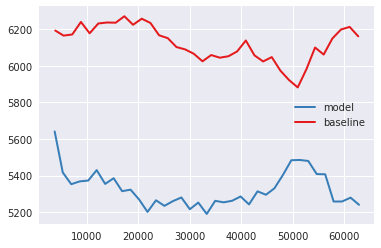

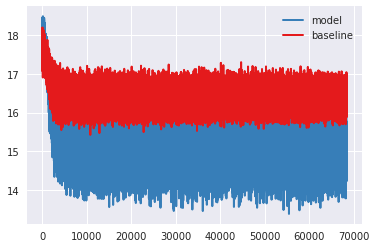

('fungi-bacteria', 'all-centers')
59
59205


100%|██████████| 22076/22076 [00:15<00:00, 1410.03it/s]


[0.2685705000577949]


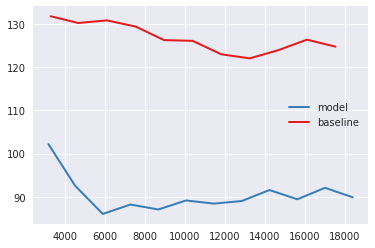

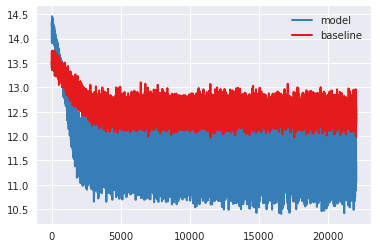

In [191]:
def retrieve_q2(model, baseline):

    # this provides a pseudo-r2 commonly provided in the context
    # of logistic / multinomail model (proposed by Cox & Snell)
    # http://www3.stat.sinica.edu.tw/statistica/oldpdf/a16n39.pdf
    end = min(10, len(model.index))
    # trim only the last 10 numbers

    # compute a q2 score, which is commonly used in
    # partial least squares for cross validation
    cv_model = model.dropna()
    cv_baseline = baseline.dropna()

    l0 = np.mean(cv_baseline['cross-validation'][-end:])
    lm = np.mean(cv_model['cross-validation'][-end:])
    q2 = 1 - lm / l0
    
    return [q2]

mmvec_results_all = {}
mmvec_q2_all = {}

latent_dim = 3

data_subsets = {}
data_subsets['all-centers'] = (bacterial_bt, fungi_bt, mftmp)

for subset_tmp, (bt1tmp, bt2tmp, mftmp) in data_subsets.items():

    bt1tmp, bt2tmp, mftmp = data_subsets[subset_tmp]

    # import data
    metadata_tmp = Metadata(mftmp)
    # bacteria
    table_one_tmp = Artifact.import_data('FeatureTable[Frequency]', bt1tmp)
    # fungi
    table_two_tmp = Artifact.import_data('FeatureTable[Frequency]', bt2tmp)
    # save subset
    metadata_tmp.save('../results/data-subsets-genus/%s_metadata_WIS.qza' % subset_tmp.lower().replace(' ','_'))
    table_one_tmp.save('../results/data-subsets-genus/%s_bacteria_table_WIS.qza' % subset_tmp.lower().replace(' ','_'))
    table_two_tmp.save('../results/data-subsets-genus/%s_fungal_table_WIS.qza' % subset_tmp.lower().replace(' ','_'))

    # perams
    tables_order = {
                    'bacteria-fungi':[table_one_tmp, table_two_tmp],
                    'fungi-bacteria':[table_two_tmp, table_one_tmp],
                   }

    for mmvec_run_type, (tmptbl1, tmptbl2) in tables_order.items():
        
        
        if mmvec_run_type == 'bacteria-fungi':
            n_iterations = 1e9
        elif  mmvec_run_type == 'fungi-bacteria':
            n_iterations = 5e10
        else:
            n_iterations = 1e8
        #batch_size_use = 10
        batch_size_use = int(0.25 * tmptbl1.view(Table).shape[1])
        total_microbe_reads = tmptbl1.view(Table).sum()
        epochs_use = max(1, int((n_iterations * batch_size_use) / total_microbe_reads))
        print((mmvec_run_type, subset_tmp))
        print(batch_size_use)
        print(epochs_use)
        # run MMvec
        model_res = paired_omics(tmptbl1,
                                 tmptbl2,
                                 latent_dim=latent_dim, 
                                 min_feature_count=10,
                                 epochs=epochs_use,
                                 batch_size=batch_size_use,
                                 metadata=metadata_tmp,
                                 training_column='traintest',
                                 summary_interval=1, 
                                 equalize_biplot=True)
        null_res = paired_omics(tmptbl1,
                                tmptbl2,
                                 latent_dim=0,
                                 min_feature_count=10,
                                 epochs=epochs_use,
                                 batch_size=batch_size_use,
                                 metadata=metadata_tmp,
                                 training_column='traintest',
                                 summary_interval=1, 
                                 equalize_biplot=True)
        #paired_model_stats = summarize_paired(model_res.model_stats, null_res.model_stats) 
        # save results
        model_res.conditionals.save('../results/mmvec-results-genus/%s-%s-conditionals-WIS.qza' % 
                                    (mmvec_run_type, subset_tmp.replace(' ','')))
        model_res.conditional_biplot.save('../results/mmvec-results-genus/%s-%s-conditional-biplot-WIS.qza' % 
                                          (mmvec_run_type, subset_tmp.replace(' ','')))
        #paired_model_stats.visualization.save('../results/mmvec-results/%s-%s-paired-model-stats.qzv' % 
        #                                      (mmvec_run_type, subset_tmp.replace(' ','')))
        mmvec_results_all[subset_tmp] = (model_res, null_res)
        # save just q2
        model_tmp = model_res.model_stats.view(Metadata).to_dataframe()
        baseline_tmp = null_res.model_stats.view(Metadata).to_dataframe()
        mmvec_q2_all[(mmvec_run_type, subset_tmp)] = retrieve_q2(model_tmp,
                                                                 baseline_tmp)
        print(mmvec_q2_all[(mmvec_run_type, subset_tmp)])
        model_tmp_cv = model_tmp.dropna().rolling(6).mean().dropna().reset_index()
        baseline_tmp_cv = baseline_tmp.dropna().rolling(6).mean().dropna().reset_index()
        plt.plot(model_tmp_cv.dropna()['iteration'], model_tmp_cv.dropna()['cross-validation'], label='model', c='#377eb8', lw=2)
        plt.plot(baseline_tmp_cv.dropna()['iteration'], baseline_tmp_cv.dropna()['cross-validation'], label='baseline', c='#e41a1c', lw=2)
        plt.legend()
        plt.show()

        plt.plot(model_tmp['iteration'], np.log(model_tmp['loss']),
                 label='model', c='#377eb8', lw=2)
        plt.plot(baseline_tmp['iteration'], np.log(baseline_tmp['loss']),
                 label='baseline', c='#e41a1c', lw=2)
        plt.legend()
        plt.show()


